In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import glob
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, SeparableConv2D
from tensorflow.keras.models import Model, load_model

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
print("TensorFlow version:", tf.__version__)

1 Physical GPUs, 1 Logical GPUs
TensorFlow version: 2.10.1


In [3]:
# Memory optimization settings
import gc
import os

# Set memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Optional: Limit GPU memory usage
        # tf.config.experimental.set_memory_limit(gpus[0], 1024)  # 1GB limit
        
    except RuntimeError as e:
        print(f"GPU setup error: {e}")

# Force garbage collection
gc.collect()

print("Memory optimization settings applied")

Memory optimization settings applied


In [4]:
# Step 2: Data Mapping Logic (Updated with Pandas)
import pandas as pd

# Configuration
DATA_DIR = Path('data/')
dataset1_path = Path('data/face_age/')
dataset2_path = Path('data/UTKFace/')


BATCH_SIZE = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224


# Verify data directory exists
if not DATA_DIR.exists():
    print(f"Error: Directory {DATA_DIR} not found.")
else:
    data =[]
    # Dataset 1: face_age
    for img_path in dataset1_path.glob("**/*.png"):
        filename = img_path.name
        age = int(img_path.parent.name)
        data.append({'path': str(img_path), 'age': age if age < 100 else 100})
    # Dataset 2: UTKFace
    for img_path in dataset2_path.glob("*.jpg"):
        filename = img_path.name
        age = int(filename.split('_')[0])
        data.append({'path': str(img_path), 'age': age if age < 100 else 100})
    
    # Tạo biến df chính thức
    df = pd.DataFrame(data)
    
    # Shuffle data (xáo trộn) để không bị sắp xếp theo thứ tự folder
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    NUM_CLASSES = df['age'].max()
    
    print(f"DataFrame created. Shape: {df.shape}")
    print(f"Total Age Groups: {NUM_CLASSES}")
    
    # Hiển thị 5 dòng đầu để kiểm tra
    print(df.head())

DataFrame created. Shape: (33486, 2)
Total Age Groups: 100
                                                path  age
0  data\UTKFace\14_0_0_20170104012341136.jpg.chip...   14
1  data\UTKFace\35_1_1_20170112215240346.jpg.chip...   35
2  data\UTKFace\76_1_0_20170112204943874.jpg.chip...   76
3  data\UTKFace\53_1_0_20170110160643329.jpg.chip...   53
4                         data\face_age\059\8098.png   59


C:\Users\PC\AppData\Local\Temp\ipykernel_13500\852923322.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='age', palette='viridis')


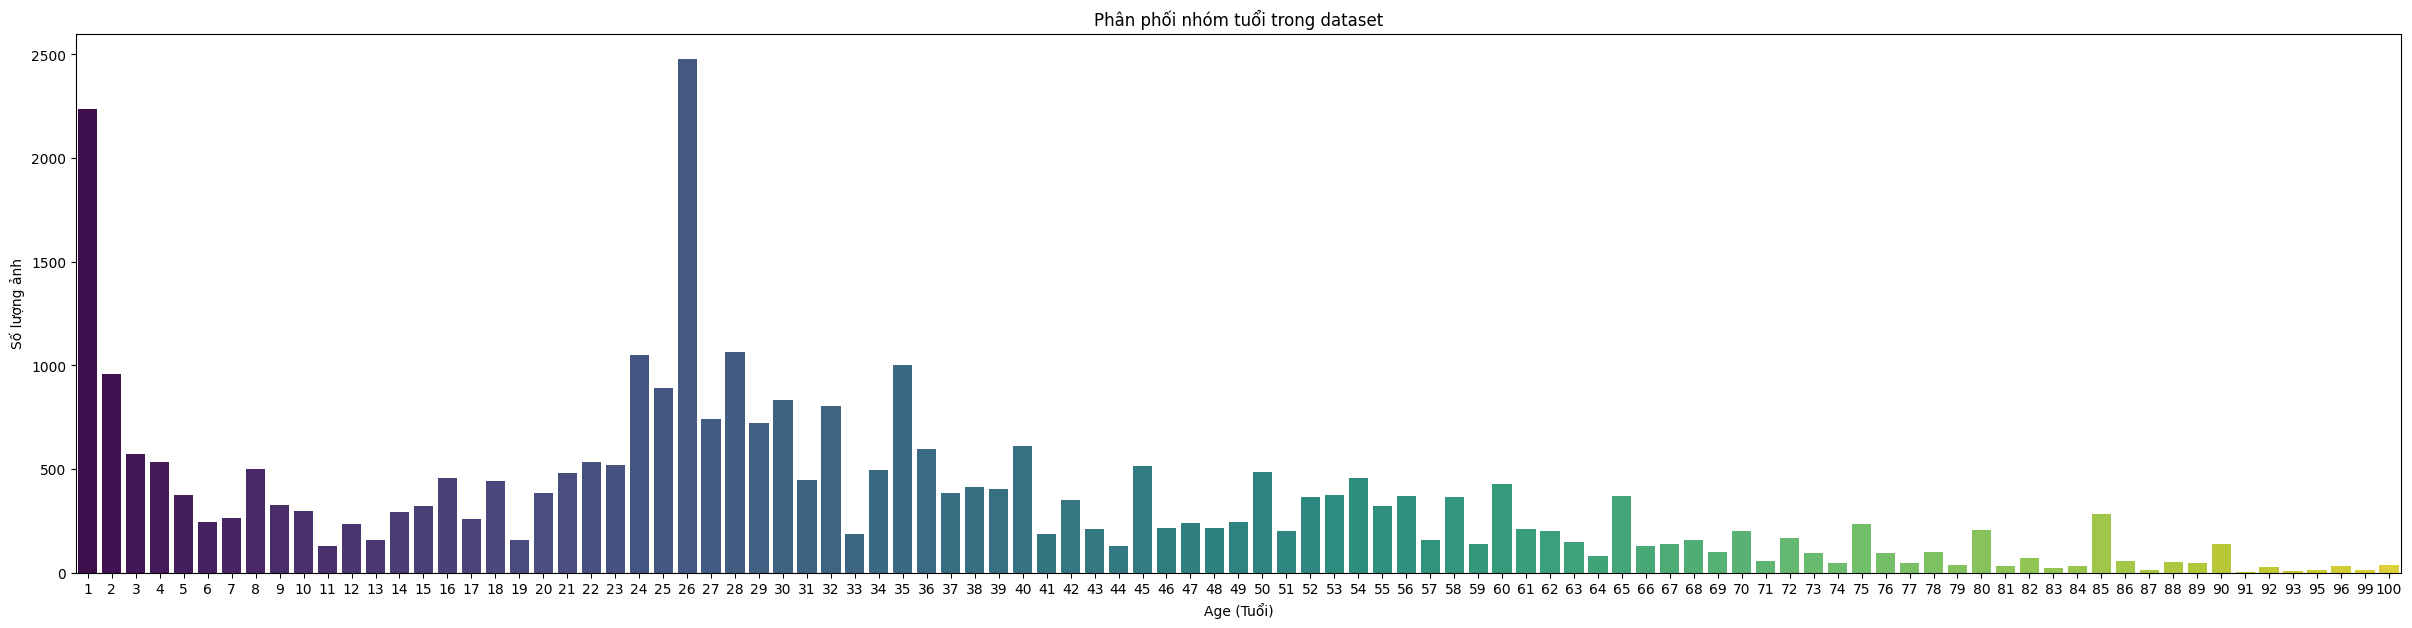

In [7]:
# Step 3: Data Visualization
plt.figure(figsize=(30, 7))
sns.countplot(data=df, x='age', palette='viridis')
plt.title('Phân phối nhóm tuổi trong dataset')
plt.xlabel('Age (Tuổi)')
plt.ylabel('Số lượng ảnh')
plt.show()


In [5]:
# Step 4 (Pre-computation): Split & Calculate Class Weights using DataFrame
# 1. Split Train/Validation (80/20)
# Stratify dựa trên cột age để đảm bảo chia đều các nhóm tuổi
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['age']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# 2. Compute Class Weights (Xử lý mất cân bằng dữ liệu)
# class_weights_vals = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_df['age']),
#     y=train_df['age']
# )

# # Chuyển về dictionary cho Keras
# class_weights_dict = dict(enumerate(class_weights_vals))
# print("Class weights computed.")

Training samples: 26788
Validation samples: 6698


In [6]:
# Step 3: Tf.data Pipeline Construction

AUTOTUNE = tf.data.AUTOTUNE

def process_path(file_path, age):
    """
    Memory-efficient image processing.
    1. Read and decode image
    2. Resize efficiently 
    3. Normalize to [0,1] range
    """
    # Load and decode image
    img = tf.io.read_file(file_path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    
    # Ensure 3 channels and convert to float32
    img = tf.ensure_shape(img, [None, None, 3])
    img = tf.cast(img, tf.float32)
    
    # Resize with memory efficiency
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH], method='bilinear')
    
    # Normalize to [0,1] range to reduce memory usage
    img = img / 255.0
    
    # Convert age to float32 for regression
    age = tf.cast(age, tf.float32)
    
    return img, age

def augment(image, label):
    """Applies random augmentation to training data."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

# Create TensorFlow Datasets with memory optimization
train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'].values, train_df['age'].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'].values, val_df['age'].values))

# Apply transformations with memory optimization
# Train: Process -> Batch -> Augment -> Prefetch (batch before augment to reduce memory)
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=1)  # Reduce prefetch buffer

# Val: Process -> Batch -> Prefetch (No augmentation)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=1)

print("Pipeline built.")
# Check shape of one batch
for image_batch, labels_batch in train_ds.take(1):
    print(f"Image Batch Shape: {image_batch.shape}")
    print(f"Label Batch Shape: {labels_batch.shape}")
    break

Pipeline built.
Image Batch Shape: (8, 224, 224, 3)
Label Batch Shape: (8,)


In [30]:
# Step 5: Model Construction
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

X = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer=glorot_uniform(seed=0))(inputs)
X = BatchNormalization()(X)

X = SeparableConv2D(64, (3, 3), padding='same', activation='relu')(X)
X = BatchNormalization()(X)
X = MaxPooling2D((2, 2))(X)

X = SeparableConv2D(128, (3, 3), padding='same', activation='relu')(X)
X = BatchNormalization()(X)
X = MaxPooling2D((2, 2))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = BatchNormalization()(X)
X = MaxPooling2D((2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = BatchNormalization()(X)
X = MaxPooling2D((2, 2))(X)

X = tf.keras.layers.GlobalAveragePooling2D()(X)

# Dense layers
X = Dense(256, activation='relu')(X)
X = Dropout(0.4)(X)
X = Dense(128, activation='relu')(X)
X = Dropout(0.4)(X)

# Output layer for age regression (no activation for regression)
output = Dense(1, name='age_output')(X)

model = Model(inputs=inputs, outputs=output)

In [31]:
# Compile for age regression
model.compile(
    loss='mse',  # Mean Squared Error for regression
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']  # Mean Absolute Error as metric
)

In [32]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 64)      1792      
                                                                 
 batch_normalization_12 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 separable_conv2d (Separable  (None, 112, 112, 64)     4736      
 Conv2D)                                                         
                                                                 
 batch_normalization_13 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                           

In [33]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    restore_best_weights=True,
    mode='min',
    patience=10,
    verbose=1
)
check_point = tf.keras.callbacks.ModelCheckpoint(
    'best_model_age.h5',
    monitor='val_mae',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train with memory optimization
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,  # Reduce epochs for testing
    callbacks=[early_stop, check_point],
    verbose=1
)

Epoch 1/30
3349/3349 [==============================] - ETA: 0s - loss: 227.0039 - mae: 11.1581
Epoch 1: val_mae improved from inf to 7.45384, saving model to best_model_age.h5
3349/3349 [==============================] - 187s 56ms/step - loss: 227.0039 - mae: 11.1581 - val_loss: 107.7467 - val_mae: 7.4538
Epoch 2/30
3347/3349 [============================>.] - ETA: 0s - loss: 143.1880 - mae: 8.6753
Epoch 2: val_mae did not improve from 7.45384
3349/3349 [==============================] - 105s 31ms/step - loss: 143.1642 - mae: 8.6750 - val_loss: 114.2826 - val_mae: 7.6454
Epoch 3/30
3347/3349 [============================>.] - ETA: 0s - loss: 119.0840 - mae: 7.9028
Epoch 3: val_mae improved from 7.45384 to 6.75273, saving model to best_model_age.h5
3349/3349 [==============================] - 105s 31ms/step - loss: 119.0784 - mae: 7.9028 - val_loss: 87.2719 - val_mae: 6.7527
Epoch 4/30
3347/3349 [============================>.] - ETA: 0s - loss: 106.6476 - mae: 7.4854
Epoch 4: val_mae 

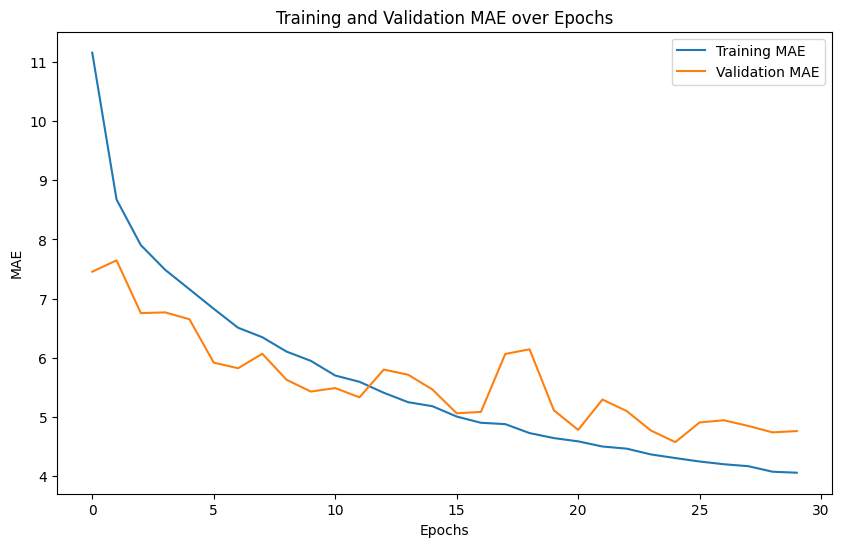

In [34]:
training_mae = model_history.history['mae']
validation_mae = model_history.history['val_mae']

plt.figure(figsize=(10, 6))
plt.plot(training_mae, label='Training MAE')
plt.plot(validation_mae, label='Validation MAE')
plt.title('Training and Validation MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

Evaluating model...
Mean Absolute Error: 4.76 years
Root Mean Square Error: 6.96 years


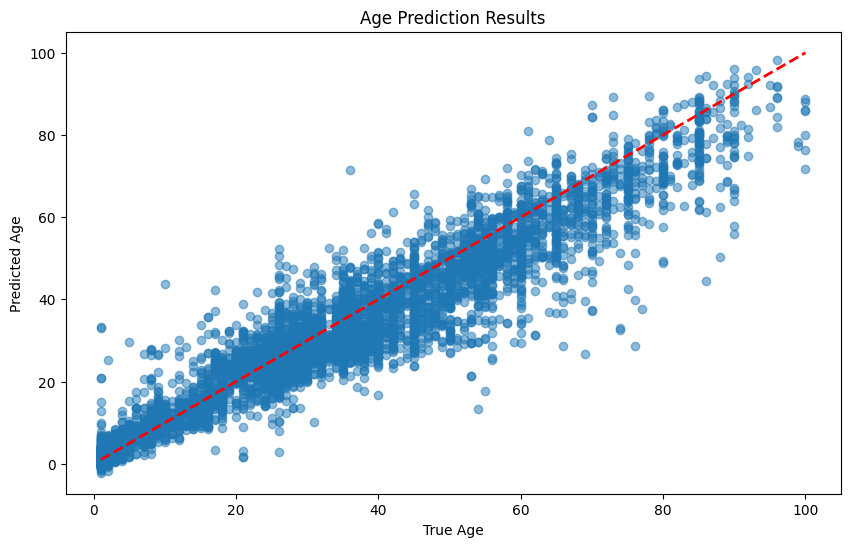

In [35]:
# Step 6: Evaluation for Age Regression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict on validation set
print("Evaluating model...")
y_true = []
y_pred = []

for images, ages in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(ages.numpy().flatten())
    y_pred.extend(preds.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae:.2f} years")
print(f"Root Mean Square Error: {rmse:.2f} years")

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Age Prediction Results')
plt.show()

In [7]:
model = load_model('best_model_age.h5')

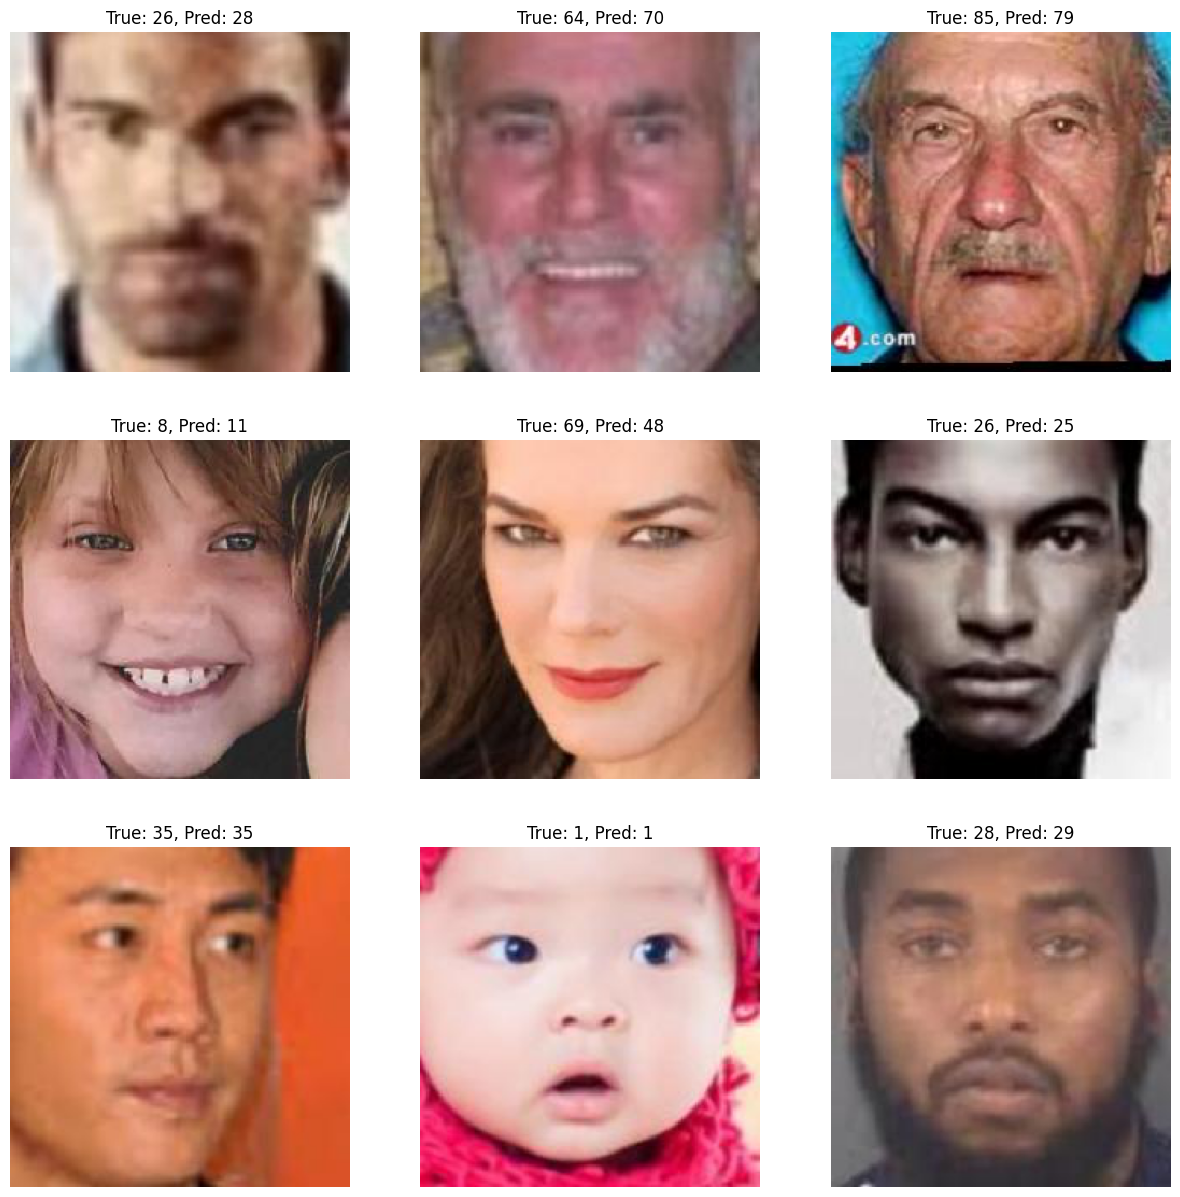

In [23]:
# Visualize some predictions
import random
random_indices = random.sample(range(len(val_df)), 9)
plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    img_path = val_df.iloc[idx]['path']
    true_age = val_df.iloc[idx]['age']
    
    # Load and preprocess image
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict age
    predicted_age = model.predict(img_array, verbose=0)[0][0]
    
    # Plotting
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'True: {true_age}, Pred: {predicted_age:.0f}')
    